# Big Data Bowl 
Ethan Douglas and Nick Wan 


## load in 

In [ ]:
!apt-get update
!pip install adjustText --quiet
!pip install shap
!apt install imagemagick

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic/main Sources [1,700 kB]
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:12 https://developer.download.nvidia.com/compute/machine-learning/repo

In [ ]:
import os 
import pickle
import time
import random
import warnings 
from IPython.display import HTML, Image
import pandas as pd 
import numpy as np 
import math
import seaborn as sns 
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
from matplotlib import rc
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import KFold, GroupKFold
from sklearn.metrics import log_loss, accuracy_score
from sklearn.preprocessing import minmax_scale
from adjustText import adjust_text

import lightgbm as lgb

import itertools

from scipy.spatial import distance

import codecs
decode_hex = codecs.getdecoder("hex_codec")

rc('animation', html='html5')

import shap
shap.initjs()

In [ ]:
def get_play_by_frame(fid, ax, los, one_play):
  ax.cla()
  gid = one_play['gameId'].unique()[0]
  pid = one_play['playId'].unique()[0]
  one_frame = one_play.loc[one_play['frameId']==fid]
  fig1 = sns.scatterplot(x='x',y='y',data=one_frame, hue='team', ax=ax, size='target_scaled', sizes=(30,150))
  fig1.axvline(los, c='k', ls=':')
  fig1.axvline(0, c='k', ls='-')
  fig1.axvline(100, c='k', ls='-')
  fig1.set_title(f"game {gid} play {pid}")
  fig1.legend([]).set_visible(False)
  sns.despine(left=True)
  fig1.set_ylabel('')

  fig1.set_yticks([])
  fig1.set_xlim(-10,110)    
  fig1.set_ylim(0,54) 

def animate_play(gid, pid, model_type):
  for fn in [f'drive/My Drive/bdb21/Data/{x}' for x in os.listdir('drive/My Drive/bdb21/Data/') if 'week' in x]:
    one_week = pd.read_csv(fn)
    _x = one_week.loc[one_week['position']=='QB',['gameId', 'playId', 'team']].drop_duplicates()
    _x['posteam'] = 1
    one_week = one_week.merge(_x, how='left')
    one_week['posteam'] = one_week['posteam'].fillna(0).astype(int)
    one_play = one_week.loc[(one_week['gameId']==gid) & (one_week['playId']==pid)]
    if not one_play.empty:
      break

  posteam_ids = one_play.loc[(one_play['posteam']==1) & (one_play['position']!='QB'),'nflId'].unique() 

  generic2receiver = pd.DataFrame(posteam_ids, columns=['nflId'])
  generic2receiver['genericId'] = range(generic2receiver.shape[0])

  steal = pd.DataFrame()

  idconversion_value = -13
  if model_type =='rf':
    idconversion_value = -9
  for col in [f'receiver_{x}_{model_type}_pred' for x in range(5)]:
    idconversion = int(col[idconversion_value])
    _join = df_pred.loc[:, ['gameId', 'playId','frameId',col]]
    _join['nflId'] = generic2receiver.loc[generic2receiver['genericId']==idconversion, 'nflId'].values[0]
    _steal = one_play.merge(_join, how='left').loc[:, ['frameId','nflId',col]].rename(columns={col:'target_prob'})
    steal = steal.append(_steal.dropna())

  one_play = one_play.merge(steal, how='left')

  scaled = pd.Series()
  for fid in one_play['frameId'].unique():
    _one_play = one_play.loc[one_play['frameId']==fid, 'target_prob']
    scaled = scaled.append(pd.Series(minmax_scale(_one_play, feature_range=(.2,1)), index=_one_play.index) )
    
  one_play['target_scaled'] = scaled.fillna(scaled.quantile(.3))
  one_play.loc[one_play['team']=='football', 'target_scaled'] = scaled.quantile(.15) 

  los = one_play.loc[(one_play['frameId']==1) & (one_play['team']=='football'), 'x'].values[0]

  fig = plt.figure()
  ax = fig.gca()
  ani = animation.FuncAnimation(fig, get_play_by_frame, 
                                frames=one_play['frameId'].sort_values().unique().shape[0],
                                interval=100, repeat=True, fargs=(ax,los,one_play,))

  plt.close()
  ani.save(f'{gid}_{pid}_{model_type}.gif', writer='imagemagick', fps=10)
  return ani

def get_one_play_to_model_data(one_play, verbose=False):
  # fuck double QB plays 
  if one_play.loc[one_play['position']=='QB', 'nflId'].unique().shape[0] > 1:
    if verbose:
      print('Double-QB play, need to fix the receiver-QB')
    return -1

  # QA for frames for every player 
  frame_qa = []
  for play_idx, fid in enumerate(one_play['frameId'].unique()):      
    if play_idx == 0:
      _frame_qa = one_play.loc[one_play['frameId']==one_play['frameId'].sample(1).values[0]].shape[0]

    frame_qa.append(_frame_qa == one_play.loc[one_play['frameId']==fid].shape[0])
  if False in frame_qa:
    if verbose:
      print('failed frame QA (missing frames for at least 1 player)')
    return -1

  # check for pass events
  pass_arrive_events = ['pass_arrived']+[x for x in one_play['event'].unique() if 'pass_outcome_' in x]
  pass_arrive_frame = one_play.loc[one_play['event'].isin(pass_arrive_events), 'frameId'].min()
  if np.isnan(pass_arrive_frame):
    if verbose:
      print("no pass detected (pass arrival and outcomes don't exist)")
    return -1

  # get QB and LOS info
  _munge = one_play.loc[one_play['position']=='QB', ['frameId', 'o']].rename(columns={'o':'qb_o'})
  _munge['los'] = one_play.loc[(one_play['frameId']==1) & (one_play['team']=='football'), 'x'].unique()[0]

  # get dist from QB 
  football_loc = one_play.loc[one_play['team']=='football', ['x', 'y']] 
  qb_loc = one_play.loc[one_play['position']=='QB', ['x', 'y']]     
  target_receiver_id = one_play['targetNflId'].unique()[0] 

  # if there isn't a target receiver, then wtf are we even doing 
  if np.isnan(target_receiver_id):
    if verbose:
      print('no intended receiver (receiver ID is nan)')
    return -1

  _x = one_play.loc[one_play['position']=='QB',['gameId', 'playId', 'team']].drop_duplicates() 
  _x['posteam'] = 1 
  one_play = one_play.merge(_x, how='left') 
  one_play['posteam'] = one_play['posteam'].fillna(0).astype(int) 

  # set some ID stuff up 
  posteam_ids = one_play.loc[(one_play['posteam']==1) & (one_play['position']!='QB'),'nflId'].unique() 
  defteam_ids = one_play.loc[(one_play['posteam']==0) & (one_play['position']!='QB') & (one_play['team']!='football'),'nflId'].unique() 
  _id2generic = {x:idx for idx,x in enumerate(posteam_ids)}
  id2generic = {x:idx for idx,x in enumerate(defteam_ids)}
  id2generic = {**id2generic, **_id2generic}

  pos_loc = one_play.loc[one_play['nflId'].isin(posteam_ids), ['x', 'y']]
  frame_ids = one_play['frameId'].unique()

  if target_receiver_id not in posteam_ids: 
    if verbose:
      print("target receiver doesn't exist??")
    return -1

  generic_receiver_id = posteam_ids.tolist().index(target_receiver_id)
  n_receivers = posteam_ids.shape[0]
  generic_receiver_cols = [f"receiver_{x}" for x in range(n_receivers)]
  receiver_id_cols = [f"receiver_id_{x}" for x in range(n_receivers)]
  football_cols = [f"football_{x}" for x in range(n_receivers)]

  # calculate the cone!! THE CONE!!! 
  _cone = pd.pivot_table(one_play.loc[one_play['nflId'].isin(posteam_ids),['frameId','nflId', 'x_std', 'y_std']], index='frameId', columns='nflId', values=['x_std', 'y_std']).reset_index()
  cone_cols = [x[0] if not x[1] else f"receiver_cone_{x[0][0]}_{id2generic[x[1]]}" for x in _cone.columns.to_flat_index()]
  _cone.columns = cone_cols
  poscone = _cone.fillna(-1)

  _cone = pd.pivot_table(one_play.loc[one_play['position']=='QB',['frameId','nflId', 'x_std', 'y_std']], index='frameId', columns='nflId', values=['x_std', 'y_std']).reset_index()
  cone_cols = [x[0] if not x[1] else f"qb_cone_{x[0][0]}" for x in _cone.columns.to_flat_index()]
  _cone.columns = cone_cols
  defcone = _cone.fillna(-1)
  cone = poscone.merge(defcone)

  df_dist = pd.DataFrame()
  _dist = pd.DataFrame(distance.cdist(qb_loc, pos_loc, 'euclidean')) 
  for idx, fid in enumerate(frame_ids):
    try:
      cols = range(idx*n_receivers,(idx*n_receivers)+n_receivers)
      _dist1 = _dist.loc[[idx], cols]
      _dist1.columns = generic_receiver_cols
      _dist1['frameId'] = fid
      _dist1['targetGenericId'] = generic_receiver_id
      _dist2 = pd.DataFrame([posteam_ids], columns=receiver_id_cols)
      _dist2['frameId'] = fid
      _dist3 = _dist1.merge(_dist2)
      df_dist = df_dist.append(_dist3, ignore_index=True)
    except: 
      if verbose:
        print('QB-to-receiver distance broke')    
      return -1

  # merge receiver-to-QB dist 
  _munge = _munge.merge(df_dist)

  # get qb-to-football dist 
  df_dist = pd.DataFrame()
  _dist = pd.DataFrame(distance.cdist(football_loc, qb_loc, 'euclidean')) 
  for idx, fid in enumerate(frame_ids):
    try:
      # cols = range(idx*n_receivers,(idx*n_receivers)+n_receivers)
      _dist1 = _dist.loc[[idx], [idx]]
      _dist1.columns = ['qb_football']
      _dist1['frameId'] = fid
      _dist1['targetGenericId'] = generic_receiver_id
      df_dist = df_dist.append(_dist1, ignore_index=True)
    except: 
      if verbose:
        print('football-to-qb distance broke')    
      return -1
  
  # merge receiver-to-football dist 
  _munge = _munge.merge(df_dist)

  # get receiver-to-football dist 
  df_dist = pd.DataFrame()
  _dist = pd.DataFrame(distance.cdist(football_loc, pos_loc, 'euclidean')) 
  for idx, fid in enumerate(frame_ids):
    try:
      cols = range(idx*n_receivers,(idx*n_receivers)+n_receivers)
      _dist1 = _dist.loc[[idx], cols]
      _dist1.columns = football_cols
      _dist1['frameId'] = fid
      _dist1['targetGenericId'] = generic_receiver_id
      df_dist = df_dist.append(_dist1, ignore_index=True)
    except: 
      if verbose:
        print('football-to-receiver distance broke')    
      return -1
  
  # merge receiver-to-football dist 
  _munge = _munge.merge(df_dist)

  # get nearest defenders to receivers  
  df_dist = pd.DataFrame()
  n_defenders = defteam_ids.shape[0]
  def_loc = one_play.loc[one_play['nflId'].isin(defteam_ids), ['x', 'y']]

  for idx, fid in enumerate(frame_ids):
    try:
      idx_range = range(idx*n_receivers,(idx*n_receivers)+n_receivers)
      col_range = range(idx*n_defenders,(idx*n_defenders)+n_defenders)

      _dist = pd.DataFrame(distance.cdist(pos_loc, def_loc, 'euclidean')) 

      _dist1 = _dist.loc[idx_range, col_range]
      _dist1.columns = range(_dist1.shape[1])
      _dist2 = _dist1.min(axis=1).to_frame().T
      _dist2.columns = [f"nearest_defender_{x}" for x in range(n_receivers)]
      _dist3 = _dist1.idxmin(axis=1).map({k:v for k,v in enumerate(defteam_ids)}).to_frame().T
      _dist3.columns = [f"defender_id_{x}" for x in range(n_receivers)]
      _dist4 = pd.concat([_dist2, _dist3], axis=1)
      _dist4['frameId'] = fid
      df_dist = df_dist.append(_dist4, ignore_index=True)      
    except:
      if verbose:
        print('receiver-to-defender distance broken')
      return -1

  # merge nearest defenders onto giganto munge staging frame
  munge = _munge.merge(df_dist).fillna(-1)

  # nearest defender to football distance 
  def_id_cols = [x for x in df_dist.columns.values if 'defender_id' in x]
  df_target_defenders = df_dist.loc[:, ['frameId'] + def_id_cols]
  df_dist = pd.DataFrame()
  for idx, fid in enumerate(frame_ids):
    try:
      target_defs = df_target_defenders.loc[df_target_defenders['frameId']==fid, def_id_cols].values[0]
      _def_loc = df_target_defenders.loc[df_target_defenders['frameId']==fid, def_id_cols].T.reset_index(drop=True)
      _def_loc.columns = ['nflId']
      def_loc2 = one_play.loc[one_play['nflId'].isin(defteam_ids), ['frameId', 'nflId','x', 'y']]
      def_loc2 = _def_loc.merge(def_loc2.loc[(def_loc2['frameId']==fid) & (def_loc2['nflId'].isin(target_defs))], how='left')
      def_loc2 = def_loc2.loc[:, ['x', 'y']]
      _dist = pd.DataFrame(distance.cdist(football_loc, def_loc2, 'euclidean')) 
      idx_range = range(idx*n_receivers,(idx*n_receivers)+n_receivers)

      _dist1 = _dist.loc[[idx]]  
      _dist1.columns = [f"def_football_{x}" for x in range(n_receivers)]
      _dist1['frameId'] = fid
      df_dist = df_dist.append(_dist1, ignore_index=True) 

    except:
      if verbose:
        print('football-to-defender distance broken')
      return -1

  # merge football-to-defender distances
  munge = munge.merge(df_dist)

  # nearest defender to QB distance 
  df_dist = pd.DataFrame()
  for idx, fid in enumerate(frame_ids):
    try:
      target_defs = df_target_defenders.loc[df_target_defenders['frameId']==fid, def_id_cols].values[0]
      _def_loc = df_target_defenders.loc[df_target_defenders['frameId']==fid, def_id_cols].T.reset_index(drop=True)
      _def_loc.columns = ['nflId']
      def_loc2 = one_play.loc[one_play['nflId'].isin(defteam_ids), ['frameId', 'nflId','x', 'y']]
      def_loc2 = _def_loc.merge(def_loc2.loc[(def_loc2['frameId']==fid) & (def_loc2['nflId'].isin(target_defs))], how='left')
      def_loc2 = def_loc2.loc[:, ['x', 'y']]
      _dist = pd.DataFrame(distance.cdist(qb_loc, def_loc2, 'euclidean')) 
      idx_range = range(idx*n_receivers,(idx*n_receivers)+n_receivers)

      _dist1 = _dist.loc[[idx]]  
      _dist1.columns = [f"def_qb_{x}" for x in range(n_receivers)]
      _dist1['frameId'] = fid
      df_dist = df_dist.append(_dist1, ignore_index=True) 

    except:
      if verbose:
        print('football-to-defender distance broken')
      return -1  
  
  # merge qb-to-defender distances
  munge = munge.merge(df_dist).merge(cone)

  # calculate target share per receiver 
  try:
    _target_share = pd.pivot_table(one_play.loc[one_play['posteam']==1,['frameId','nflId', 'target_share']], index='frameId', columns='nflId', values=['target_share']).reset_index()
    _target_share.columns = [x[0] if not x[1] else x[1] for x in _target_share.columns.to_flat_index()]
    _target_share.columns = [x if x=='frameId' else f"target_share_{id2generic[float(x)]}" if x in id2generic.keys() else None for idx, x in enumerate(_target_share.columns.values)]
    _target_share_cols = [x for x in _target_share.columns.values if x != None]
    df_target_share = _target_share.loc[:, _target_share_cols]
  except: 
    print('target share is broke AF') 
    return -1  
  # merge target share back 
  munge = munge.merge(df_target_share)

  munge['gameId'] = one_play['gameId'].unique()[0]
  munge['playId'] = one_play['playId'].unique()[0]
  target_generic_id = munge['targetGenericId'].unique()[0]
  munge['targetDefenderId'] = munge.loc[munge['frameId']==pass_arrive_frame, f'defender_id_{target_generic_id}'].values[0]
  return munge

def get_model_data_to_model_pred(model_data, model, suffix='_pred'):
  model_feats = ['frameId','qb_o', 'los', 'receiver_0', 'receiver_1', 'receiver_2',
               'receiver_3', 'receiver_4', 'qb_football', 'football_0', 
               'football_1', 'football_2', 'football_3', 'football_4', 
               'nearest_defender_0', 'nearest_defender_1', 'nearest_defender_2', 
               'nearest_defender_3', 'nearest_defender_4','def_football_0', 
               'def_football_1', 'def_football_2', 'def_football_3', 
               'def_football_4', 'def_qb_0', 'def_qb_1', 'def_qb_2', 
               'def_qb_3', 'def_qb_4', 'receiver_cone_x_0', 
               'receiver_cone_x_1', 'receiver_cone_x_2', 'receiver_cone_x_3',
               'receiver_cone_x_4', 'receiver_cone_y_0', 'receiver_cone_y_1',
               'receiver_cone_y_2', 'receiver_cone_y_3', 'receiver_cone_y_4',
               'qb_cone_x', 'qb_cone_y', 'target_share_0', 'target_share_1', 'target_share_2',
               'target_share_3', 'target_share_4', 'down', 'yardsToGo', 'possessionTeam_codes']
  target = 'targetGenericId' 
  model_data = model_data.fillna(-1)

  missingno = [x for x in model_feats if x not in model_data.columns.values]
  for col in missingno:
    model_data[col] = -1

  pred = pd.DataFrame(model.predict(model_data.loc[:, model_feats]), 
                      index=model_data.index, 
                      columns=[f"receiver_{x}{suffix}" for x in range(5)])
  df_output = model_data.merge(pred, left_index=True, right_index=True)
  return df_output  

def get_model_pred_unpacked(model_data, suffix='_pred'):
  target_defender_id = model_data['targetDefenderId'].unique()[0]
  df_unpack = pd.DataFrame()
  for idx in range(5):
    x = model_data.loc[:, ['gameId', 'playId','frameId', f'receiver_id_{idx}', f'receiver_{idx}{suffix}']].rename(columns={f'receiver_id_{idx}':'nflId', f'receiver_{idx}{suffix}':'targetReceiverProb'})
    y = model_data.loc[:, ['gameId', 'playId','frameId', f'defender_id_{idx}', f'receiver_{idx}{suffix}']].rename(columns={f'defender_id_{idx}':'nflId', f'receiver_{idx}{suffix}':'targetReceiverProb'})
    df_unpack = df_unpack.append(x, ignore_index=True).append(y, ignore_index=True)
  df_unpack['targetDefenderId'] = target_defender_id
  return df_unpack  

def get_target_proba(one_play, model, suffix='_pred'):
  model_data = get_one_play_to_model_data(one_play)
  model_data = get_model_data_to_model_pred(model_data, model)
  df_unpack = get_model_pred_unpacked(model_data, suffix=suffix)
  one_play = one_play.merge(df_unpack,how='left')
  one_play['targetReceiverProb'] = one_play['targetReceiverProb'].fillna(0)
  one_play['targetDefenderId'] = one_play['targetDefenderId'].fillna(method='ffill').fillna(method='bfill')
  return one_play  

def animate_predicted_play(one_play, suffix='_pred'):    
  gid = one_play['gameId'].unique()[0]
  pid = one_play['playId'].unique()[0]

  scaled = pd.Series()
  for fid in one_play['frameId'].unique():
    _one_play = one_play.loc[one_play['frameId']==fid, 'targetReceiverProb']
    scaled = scaled.append(pd.Series(minmax_scale(_one_play, feature_range=(.2,1)), index=_one_play.index))
    
  one_play['target_scaled'] = scaled.fillna(scaled.quantile(.3))
  one_play.loc[one_play['team']=='football', 'target_scaled'] = scaled.quantile(.15) 

  los = one_play.loc[(one_play['frameId']==1) & (one_play['team']=='football'), 'x'].values[0]

  fig = plt.figure()
  ax = fig.gca()
  ani = animation.FuncAnimation(fig, get_play_by_frame, 
                                frames=one_play['frameId'].sort_values().unique().shape[0],
                                interval=100, repeat=True, fargs=(ax,los,one_play,))

  plt.close()
  ani.save(f'{gid}_{pid}.gif', writer='imagemagick', fps=10)
  return ani    

In [ ]:
project_dir = 'drive/My Drive/bdb21'
targeted_receiver_fns = [f"{project_dir}/Data/{x}" for x in os.listdir(f'{project_dir}/Data') if 'target' in x]
weeks_fns = [f"{project_dir}/Data/{x}" for x in os.listdir(f'{project_dir}/Data') if ('coverages_' not in x) & ('week' in x)]
players_fns = [f"{project_dir}/Data/{x}" for x in os.listdir(f'{project_dir}/Data') if 'players' in x]
games_fns = [f"{project_dir}/Data/{x}" for x in os.listdir(f'{project_dir}/Data') if 'games' in x]
plays_fns = [f"{project_dir}/Data/{x}" for x in os.listdir(f'{project_dir}/Data') if 'plays' in x]
df_players = pd.read_csv(players_fns[0])
df_targeted_receiver = pd.read_csv(targeted_receiver_fns[0])

# i merge games and plays right here 
df_games = pd.read_csv(games_fns[0])
df_plays = pd.read_csv(plays_fns[0])
df_plays = df_plays.merge(df_games)
df_plays = df_plays.merge(df_targeted_receiver)
df_plays['possessionTeam_codes'] = df_plays['possessionTeam'].astype('category').cat.codes

_player = df_plays.loc[:, ['gameId', 'possessionTeam', 'targetNflId', 'playId']].groupby(['gameId', 'possessionTeam','targetNflId'], as_index=False).count().rename(columns={'playId':'targets'}).sort_values(['targetNflId','possessionTeam', 'gameId']).reset_index(drop=True)
for idx, row in _player.loc[:, ['possessionTeam', 'targetNflId']].drop_duplicates().iterrows():
  _player.loc[(_player['possessionTeam']==row['possessionTeam']) & (_player['targetNflId']==row['targetNflId']), 'targets'] = _player.loc[(_player['possessionTeam']==row['possessionTeam']) & (_player['targetNflId']==row['targetNflId']), 'targets'].cumsum().shift(1).fillna(0)

_team = df_plays.loc[:, ['gameId', 'possessionTeam', 'playId']].groupby(['gameId', 'possessionTeam'], as_index=False).count().rename(columns={'playId':'snaps'}).sort_values(['possessionTeam', 'gameId']).reset_index(drop=True)
for team in _team['possessionTeam'].unique():
  _team.loc[_team['possessionTeam']==team, 'snaps'] = _team.loc[_team['possessionTeam']==team, 'snaps'].cumsum().shift(1).fillna(0)

target_share = _player.merge(_team)
target_share['target_share'] = target_share['targets'].div(target_share['snaps'])

(986022, 22)

# Munge

In [ ]:
# This munge takes raw data and converts it into data for use in our models 
target_events = ['ball_snap', 'pass_forward', 'pass_arrived'] + [x for x in one_week['event'].unique() if 'pass_outcome_' in x]

for weeks_fn in tqdm(weeks_fns, leave=False):
  df_rel_dist = pd.DataFrame()
  fn = weeks_fn.split('/')[-1].split('.')[0]
  if os.path.isfile(f"{project_dir}/processed_data/df_rel_dist_{fn}.csv"):
    continue

  one_week = pd.read_csv(weeks_fn)
  one_week = one_week.merge(df_targeted_receiver)
  one_week['intended_receiver'] = (one_week['targetNflId'] == one_week['nflId']).astype(int)
  one_week['toLeft'] = one_week['playDirection'] == "left"
  one_week['x_std'] = one_week['x']
  one_week.loc[one_week['toLeft'], 'x_std'] = 120 - one_week.loc[one_week['toLeft'], 'x'] 
  one_week['y_std'] = one_week['y']
  one_week.loc[one_week['toLeft'], 'y_std'] = 160/3 - one_week.loc[one_week['toLeft'], 'y']

  # identify the team with possession 
  _x = one_week.loc[one_week['position']=='QB',['gameId', 'playId', 'team']].drop_duplicates()
  _x['posteam'] = 1
  one_week = one_week.merge(_x, how='left')
  one_week['posteam'] = one_week['posteam'].fillna(0).astype(int)  
  _one_week = one_week.loc[one_week['frameId']==1].copy()
  one_week = one_week.loc[one_week['event'].isin(target_events)].append(_one_week, ignore_index=True)
  one_week = one_week.merge(target_share.rename(columns={'targetNflId':'nflId'}), how='left')
  one_week['target_share'] = one_week['target_share'].fillna(0)
  one_week['Orientation_rad'] = np.mod(-one_week.o + 90, 360) * math.pi/180.0
  one_week['Orientation_std'] = one_week.Orientation_rad
  one_week.loc[one_week.toLeft, 'Orientation_std'] = np.mod(np.pi + one_week.loc[one_week.toLeft, 'Orientation_rad'], 2*np.pi)
  one_week['o'] = one_week['Orientation_std']

  total = one_week.loc[:, ['gameId', 'playId']].drop_duplicates().shape[0]
  for row_idx, one_play in tqdm(one_week.loc[:, ['gameId', 'playId']].drop_duplicates().iterrows(), leave=False, total=total):
    one_play = one_play.to_frame().T.merge(one_week)    
    one_play = get_one_play_to_model_data(one_play)
    if type(one_play) == int:
      continue
    df_rel_dist = df_rel_dist.append(one_play.fillna(-1), ignore_index=True) 

  df_rel_dist.to_csv(f"{project_dir}/processed_data/df_rel_dist_{fn}.csv", index=False)      
  print(df_rel_dist.shape)

In [ ]:
# load in all the relative distance dataframes (model data) 
rel_dist_fns = [f"{project_dir}/processed_data/{x}" for x in os.listdir(f"{project_dir}/processed_data/") if ('df_rel_dist_' in x) and ('.csv' in x)]
for idx, fn in enumerate(rel_dist_fns[:16]):
  if idx == 0:
    df_rel_dist = pd.read_csv(fn)
  else:
    df_rel_dist = df_rel_dist.append(pd.read_csv(fn))
df_rel_dist = df_rel_dist.loc[df_rel_dist['targetGenericId']<=4]
df_rel_dist.loc[df_rel_dist['football_4'].isnull()] = df_rel_dist.loc[df_rel_dist['football_4'].isnull()].fillna(-1)
df_rel_dist = df_rel_dist.fillna(-1)
df_rel_dist = df_rel_dist.merge(df_plays.loc[:, ['gameId', 'playId','down', 'yardsToGo', 'possessionTeam_codes']].drop_duplicates())
df_rel_dist['game_play'] = df_rel_dist.loc[:, ['gameId','playId']].sum(axis=1)
df_rel_dist.shape    

(78590, 114)

# gbm validation  
10-fold cross val, checked against predicting using the mean ("naive model")  

this using group blocking by game + play, so as to not overfit a fold on a given play. 

In [ ]:
model_feats = ['frameId','qb_o', 'los', 'receiver_0', 'receiver_1', 'receiver_2',
               'receiver_3', 'receiver_4', 'qb_football', 'football_0', 
               'football_1', 'football_2', 'football_3', 'football_4', 
               'nearest_defender_0', 'nearest_defender_1', 'nearest_defender_2', 
               'nearest_defender_3', 'nearest_defender_4','def_football_0', 
               'def_football_1', 'def_football_2', 'def_football_3', 
               'def_football_4', 'def_qb_0', 'def_qb_1', 'def_qb_2', 
               'def_qb_3', 'def_qb_4', 'receiver_cone_x_0', 
               'receiver_cone_x_1', 'receiver_cone_x_2', 'receiver_cone_x_3',
               'receiver_cone_x_4', 'receiver_cone_y_0', 'receiver_cone_y_1',
               'receiver_cone_y_2', 'receiver_cone_y_3', 'receiver_cone_y_4',
               'qb_cone_x', 'qb_cone_y', 'target_share_0', 'target_share_1', 'target_share_2',
               'target_share_3', 'target_share_4', 'down', 'yardsToGo', 'possessionTeam_codes']

target = 'targetGenericId' 
kf = GroupKFold(10) 
df_pred = pd.DataFrame()
for model_idx, (train_idx, test_idx) in tqdm(enumerate(kf.split(df_rel_dist, groups=df_rel_dist['game_play'])), leave=False):
  train_data = df_rel_dist.iloc[train_idx]
  test_data = df_rel_dist.iloc[test_idx] 

  lgb_train = lgb.Dataset(train_data.loc[:, model_feats], train_data[target], categorical_feature=['possessionTeam_codes'])
  lgb_test = lgb.Dataset(test_data.loc[:, model_feats], test_data[target], categorical_feature=['possessionTeam_codes'])

  p = dict(objective='multiclass', 
           num_class=df_rel_dist['targetGenericId'].unique().shape[0], 
           max_cat_threshold=2, 
           cat_l2=20)
  model = lgb.train(p,lgb_train,num_boost_round=4000, valid_sets=lgb_test, early_stopping_rounds=200, verbose_eval=200)
  if len(str(model_idx))==1:
    model_idx = f"0{model_idx}"
  filename = f"{project_dir}/models/{time.strftime('%Y%m%d%H%M%S')}_target_receiver_probability_{model_idx}.model"
  model.save_model(filename)
  _pred = pd.DataFrame(model.predict(test_data.loc[:, model_feats]), index=test_data.index, columns=[f"receiver_{x}_gbm_pred" for x in range(5)])
  test_data = test_data.merge(_pred, left_index=True, right_index=True)
  test_data['model'] = model_idx
  df_pred = df_pred.append(test_data)

df_pred = df_pred.groupby(['model','gameId', 'playId', 
                           'targetGenericId', 'receiver_id_0', 'receiver_id_1', 
                           'receiver_id_2', 'receiver_id_3', 'receiver_id_4', 
                           'defender_id_0', 'defender_id_1', 'defender_id_2', 
                           'defender_id_3', 'defender_id_4']+model_feats, as_index=False).mean()
df_pred.shape 

In [ ]:
filename = f"{project_dir}/models/{time.strftime('%Y%m%d%H%M%S')}_target_receiver_probability_model_lkup.csv"
df_pred.loc[:, ['gameId', 'playId', 'model']].to_csv(filename, index=False) 

In [ ]:
pred_cols = ['receiver_0_gbm_pred', 'receiver_1_gbm_pred', 'receiver_2_gbm_pred',
             'receiver_3_gbm_pred', 'receiver_4_gbm_pred']
print(f"my loss: {log_loss(df_pred['targetGenericId'], df_pred.loc[:, pred_cols])}")

heartbreaker = pd.DataFrame(np.repeat([[.2],[.2],[.2],[.2],[.2]], repeats=df_pred.shape[0], axis=1)).T
print(f"naive loss: {log_loss(df_pred['targetGenericId'], heartbreaker)}")


my loss: 0.9442014695401869
naive loss: 1.6094379124340998


In [ ]:
df_pred['targetGenericId_pred'] = df_pred.loc[:, ['receiver_0_gbm_pred', 'receiver_1_gbm_pred', 'receiver_2_gbm_pred',
             'receiver_3_gbm_pred', 'receiver_4_gbm_pred']].idxmax(axis=1).str[-10].astype(int)

print(f"naive acc: {accuracy_score(df_pred['targetGenericId'], np.repeat([0],repeats=df_pred.shape[0]))}")
print(f"my acc: {accuracy_score(df_pred['targetGenericId'], df_pred['targetGenericId_pred'])}")

naive acc: 0.21104466217075965
my acc: 0.5874793230690928


# Predict out  

this gets the target probability per event (or per frame if that's what you want). The way we designed it is the event probability from snap to pass forward. 

In [ ]:
df_target_probs = pd.DataFrame()
target_prob_lkups = [f"{project_dir}/models/{x}" for x in os.listdir(f"{project_dir}/models") if 'target_receiver_probability_model_lkup' in x]
target_prob_lkups.sort(reverse=True)
lkup_fn = target_prob_lkups[0]
model_lkup = pd.read_csv(lkup_fn)

sad_plays = pd.DataFrame()

for fn in tqdm(weeks_fns, leave=False):
  one_week = pd.read_csv(fn)
  one_week = one_week.merge(df_targeted_receiver)  
  one_week['toLeft'] = one_week['playDirection'] == "left"
  one_week['x_std'] = one_week['x']
  one_week.loc[one_week['toLeft'], 'x_std'] = 120 - one_week.loc[one_week['toLeft'], 'x'] 
  one_week['y_std'] = one_week['y']
  one_week.loc[one_week['toLeft'], 'y_std'] = 160/3 - one_week.loc[one_week['toLeft'], 'y']
  one_week.loc[one_week['targetNflId'].notnull(), ['gameId', 'playId']].drop_duplicates().merge(one_week)
  _x = one_week.loc[one_week['position']=='QB',['gameId', 'playId', 'team']].drop_duplicates()
  _x['posteam'] = 1
  one_week = one_week.merge(_x, how='left')
  one_week['posteam'] = one_week['posteam'].fillna(0).astype(int)  
  one_week = one_week.merge(target_share.rename(columns={'targetNflId':'nflId'}), how='left')
  one_week['target_share'] = one_week['target_share'].fillna(0)
  one_week['Orientation_rad'] = np.mod(-one_week.o + 90, 360) * math.pi/180.0
  one_week['Orientation_std'] = one_week.Orientation_rad
  one_week.loc[one_week.toLeft, 'Orientation_std'] = np.mod(np.pi + one_week.loc[one_week.toLeft, 'Orientation_rad'], 2*np.pi)
  one_week['o'] = one_week['Orientation_std']

  total = one_week.loc[:, ['gameId', 'playId']].drop_duplicates().shape[0]
  for idx, row in tqdm(one_week.loc[:, ['gameId', 'playId']].drop_duplicates().iterrows(), leave=False, total=total):
    _sad_plays = pd.DataFrame()
    try:
      _one_play = row.to_frame().T
      model_fold = model_lkup.merge(_one_play)
      model_fold = model_fold.loc[:, 'model'].unique()[0]

      target_prob_models = [f"{project_dir}/models/{x}" for x in os.listdir(f"{project_dir}/models") if f'target_receiver_probability_0{model_fold}' in x]
      target_prob_models.sort(reverse=True)
      model_fn = target_prob_models[0]
      model = lgb.Booster(model_file=model_fn)

      one_play = _one_play.merge(one_week)
      one_play = get_target_proba(one_play, model)

      one_play['w_targetReceiverProb'] = one_play['targetReceiverProb'].mul(one_play['frameId'])

      frame_start = one_play.loc[one_play['event']=='ball_snap', 'frameId'].values[0]
      frame_end = one_play.loc[one_play['event']=='pass_forward', 'frameId'].values[0]

      x = one_play.loc[one_play['event']=='ball_snap', ['gameId','playId','nflId', 'displayName', 'targetNflId', 'targetDefenderId', 'targetReceiverProb']].groupby(['gameId','playId','nflId', 'displayName', 'targetNflId', 'targetDefenderId'], as_index=False).max()
      x = x.rename(columns={'targetReceiverProb':'targetReceiverProb_ball_snap'})
      y = one_play.loc[one_play['event']=='pass_forward', ['gameId','playId','nflId', 'displayName', 'targetNflId', 'targetDefenderId', 'targetReceiverProb']].groupby(['gameId','playId','nflId', 'displayName', 'targetNflId', 'targetDefenderId'], as_index=False).max()
      y = y.rename(columns={'targetReceiverProb':'targetReceiverProb_pass_forward'})
      z = one_play.loc[one_play['frameId'].between(frame_start, frame_end), ['gameId','playId','nflId', 'displayName', 'targetNflId', 'targetDefenderId', 'targetReceiverProb']].groupby(['gameId','playId','nflId', 'displayName', 'targetNflId', 'targetDefenderId'], as_index=False).mean()
      z = z.rename(columns={'targetReceiverProb':'targetReceiverProb_stage1'})
      a = one_play.loc[one_play['frameId']==frame_end-10, ['gameId','playId','nflId', 'displayName', 'targetNflId', 'targetDefenderId', 'targetReceiverProb']].groupby(['gameId','playId','nflId', 'displayName', 'targetNflId', 'targetDefenderId'], as_index=False).max()
      a = a.rename(columns={'targetReceiverProb':'targetReceiverProb_pre_pass_forward'})      
      b = one_play.loc[one_play['frameId'].between(frame_start, frame_end), ['gameId','playId','nflId', 'displayName', 'targetNflId', 'targetDefenderId', 'w_targetReceiverProb']].groupby(['gameId','playId','nflId', 'displayName', 'targetNflId', 'targetDefenderId'], as_index=False).sum()
      b['w_targetReceiverProb'] = b['w_targetReceiverProb'].div(np.sum(np.arange(frame_start, frame_end)))
      c = x.merge(a).merge(y).merge(z).merge(b)
      df_target_probs = df_target_probs.append(c, ignore_index=True)

    except:
      _sad_plays['gameId'] = [row['gameId']]
      _sad_plays['playId'] = row['playId']
      sad_plays = sad_plays.append(_sad_plays, ignore_index=True)
      continue

  df_target_probs.to_csv(f"{project_dir}/processed_data/df_target_probs_stage1.csv", index=False)

In [ ]:
fns = [f"{project_dir}/processed_data/{x}" for x in os.listdir(f"{project_dir}/processed_data") if 'df_target_probs_stage1.csv' in x]
df_target_probs = pd.DataFrame()
for fn in fns:
  df_target_probs = df_target_probs.append(pd.read_csv(fn))

df_target_probs = df_target_probs.merge(target_share.loc[:, ['gameId','targetNflId','target_share']], how='left')
df_target_probs['target_share'] = df_target_probs['target_share'].fillna(0)  
_df_plays = df_plays.loc[df_plays['possessionTeam']==df_plays['homeTeamAbbr'], 'visitorTeamAbbr']
_df_plays = _df_plays.append(df_plays.loc[df_plays['possessionTeam']!=df_plays['homeTeamAbbr'], 'homeTeamAbbr'])
df_plays['defTeam'] = _df_plays
df_target_probs = df_target_probs.merge(df_plays.loc[:, ['gameId', 'playId', 'defTeam']].drop_duplicates())
df_target_probs.shape

(218284, 13)

In [ ]:
secondary = ['CB', 'SS', 'FS', 'DB', 'S']
linebacker = ['MLB', 'OLB', 'ILB', 'LB']
dline = ['DE', 'DT', 'NT']

In [ ]:
target_col = 'targetReceiverProb_ball_snap'
def_pos = ['CB', 'SS', 'MLB', 'OLB', 'FS','DE','ILB', 'DB', 'S','NT','DT']
def_pos = secondary
snap_counts = df_target_probs.loc[:, ['defTeam','nflId',target_col]].groupby(['defTeam','nflId'], as_index=False).count().rename(columns={target_col:'snaps'})
_df_agg = df_target_probs.merge(df_players.loc[df_players['position'].isin(def_pos), ['nflId']])
_df_agg = _df_agg.loc[:, ['defTeam','nflId', target_col]].groupby(['defTeam','nflId'], as_index=False).sum().rename(columns={target_col:'sum'})
df_agg = df_target_probs.loc[df_target_probs['nflId']==df_target_probs['targetDefenderId'], ['defTeam', 'nflId', target_col]].groupby(['defTeam', 'nflId'], as_index=False).count().rename(columns={target_col:'count'})
_target_share_agg = df_target_probs.loc[df_target_probs['nflId']==df_target_probs['targetDefenderId'], ['defTeam', 'nflId', 'target_share']].groupby(['defTeam','nflId'], as_index=False).mean()
df_agg = df_agg.merge(_df_agg)
df_agg['targets_over_expected'] = df_agg['count'].sub(df_agg['sum']) 
df_agg = df_players.merge(df_agg).merge(snap_counts).merge(_target_share_agg)
df_agg['toe_per_snap'] = df_agg['targets_over_expected'].div(df_agg['snaps'])
df_agg.rename(columns={'sum':'expected_targets',
                      'count':'targets'}, inplace=True)
df_agg['avg_expected_targets'] = df_agg['expected_targets'].div(df_agg['snaps'])
df_agg.sort_values('expected_targets', ascending=True).head(20)


,nflId,height,weight,birthDate,collegeName,position,displayName,defTeam,count,sum,targets_over_expected,snaps,target_share,toe_per_snap
47,2560970,73,200,1997-02-26,Wake Forest,S,Jessie Bates,CIN,47,10.255175,36.744825,555,0.113688,0.066207
133,2558176,72,202,1993-12-10,Alabama,FS,Eddie Jackson,CHI,45,8.341004,36.658996,465,0.103009,0.078837
166,2558183,72,209,1995-12-19,Boston College,SS,John Johnson,LA,51,16.999574,34.000426,454,0.103958,0.074891
59,2558065,71,185,1995-09-18,Southern California,CB,Adoree' Jackson,TEN,99,66.407623,32.592377,438,0.113503,0.074412
77,2556571,70,190,1993-09-20,Auburn,CB,Jonathan Jones,NE,76,44.531757,31.468243,302,0.107576,0.104199
13,2558168,74,209,1995-08-29,West Virginia,CB,Rasul Douglas,PHI,70,39.031259,30.968741,322,0.117615,0.096176
157,2552262,69,197,1993-01-22,Texas,SS,Quandre Diggs,DET,48,17.403415,30.596585,441,0.092934,0.069380
109,2543830,73,205,1992-06-25,North Carolina,FS,Tre Boston,ARI,42,11.523729,30.476271,430,0.115118,0.070875
72,2560851,73,204,1997-02-15,Stanford,SS,Justin Reid,HOU,42,12.917443,29.082557,433,0.132794,0.067165
121,2555175,73,212,1993-08-04,Samford,CB,James Bradberry,CAR,97,68.439783,28.560217,471,0.178571,0.060637


In [ ]:

pb_ap = ['Kevin Byard', 'Eddie Jackson', 'Xavien Howard', 'Harrison Smith', 
         'Kyle Fuller', 'Darius Slay', 'Stephon Gilmore', 'Jalen Ramsey', 
         'Derwin James', 'Byron Jones', 'Chris Harris', 'Patrick Peterson', 
         'Malcolm Jenkins', 'Eric Weddle', 'Adrian Phillips', 'Landon Collins',
        'Byron Jones', 'Xavien Howard', 'Jamal Adams',  'Desmond King']
df_text = df_agg.loc[(df_agg['displayName'].isin(pb_ap))]
df_agg['tpoe'] = df_agg['targets_over_expected']*-1
texts = [plt.text(x['expected_targets'],x['tpoe'],x['displayName'], fontsize=12) for idx,x in df_text.loc[:,['expected_targets','tpoe','displayName']].iterrows()]
sns.scatterplot(x='expected_targets',y='tpoe',data=df_agg,alpha=.3, hue='position', s=350)
plt.axvline(df_agg['expected_targets'].mean(), c='k', ls=':')
plt.axhline(df_agg['tpoe'].mean(), c='k', ls=':')
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='k', lw=0.5))
plt.ylabel('Targets Prevented Over Expected')
plt.xlabel('Expected Targets')
plt.title('2018 All-Pro or Pro Bowl nomination')
sns.despine()
plt.legend(loc='upper left')
plt.show()

In [ ]:
plays = pd.read_csv('plays.csv')
plays['game_play'] = plays['gameId'].astype(str) + plays['playId'].astype(str)
games = pd.read_csv('games.csv')
plays = pd.merge(plays,games)

In [ ]:
plays['defTeam'] = plays['homeTeamAbbr']
plays.loc[(plays['possessionTeam']==plays['homeTeamAbbr']), 'defTeam'] = plays['visitorTeamAbbr'].loc[(plays['possessionTeam']==plays['homeTeamAbbr'])]
team_success = plays.groupby(by=['defTeam'])['epa'].sum().to_frame().reset_index()
top_cbs = pd.merge(top_cbs, team_success)

In [ ]:
import os
import urllib.request
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
urls = pd.read_csv('https://raw.githubusercontent.com/statsbylopez/BlogPosts/master/nfl_teamlogos.csv')

for i in range(0,len(urls)):
    urllib.request.urlretrieve(urls['url'].iloc[i], os.getcwd() + '/logos/' + urls['team_code'].iloc[i] + '.png')
    
def getImage(path): 
    return OffsetImage(plt.imread(path), zoom=.5)

logos = os.listdir(os.getcwd() + '/logos')

logo_paths = []

for i in logos:
    logo_paths.append(os.getcwd() + '/logos/' + str(i))

top_cbs.loc[(top_cbs['defTeam']=='OAK'), 'defTeam'] = 'LV'

In [ ]:
x = top_cbs.tpoe
y = top_cbs.epa


fig, ax = plt.subplots(figsize=(15,15))


ax.scatter(x, y, s=.001)
for x0, y0, path in zip(x, y, logo_paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False, fontsize=4)
    ax.add_artist(ab)

plt.axvline(top_cbs['tpoe'].mean(), c='k', ls=':')
plt.axhline(top_cbs['epa'].mean(), c='k', ls=':')
plt.ylabel('Total Expected Points Allowed')
plt.xlabel('\nTop Cornerback\'s TPOE')

sns.despine()

# END OF BIG DATA BOWL SUBMISSION - REST OF CODE IS FOR THINGS NOT SUBMITTED

In [ ]:
_df_text = df_agg.loc[(df_agg['expected_targets']>df_agg['expected_targets'].mean()) & (df_agg['targets_over_expected']>df_agg['targets_over_expected'].mean())].sort_values('targets_over_expected', ascending=False).head(15)
df_text = df_agg.loc[(df_agg['expected_targets']>df_agg['expected_targets'].mean()) & (df_agg['targets_over_expected']>df_agg['targets_over_expected'].mean())].sort_values('expected_targets', ascending=False).head(15)
df_text = df_text.append(_df_text)
df_text = df_text.loc[df_text.duplicated()]

texts = [plt.text(x['expected_targets'],x['targets_over_expected'],x['displayName']) for idx,x in df_text.loc[:,['expected_targets','targets_over_expected','displayName']].iterrows()]
sns.scatterplot(x='expected_targets',y='targets_over_expected',data=df_agg,alpha=.3)
plt.axvline(df_agg['expected_targets'].mean(), c='k', ls=':')
plt.axhline(df_agg['targets_over_expected'].mean(), c='k', ls=':')
# plt.xlim(20,80)
# plt.ylim(-2.5,15)
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='k', lw=0.5))
plt.title('Targeted a lot, covering primary targets')
sns.despine()

plt.show()


In [ ]:
# _df_text = df_agg.loc[(df_agg['target_share']<=df_agg['target_share'].mean()) & (df_agg['targets_over_expected']<=df_agg['targets_over_expected'].mean())].sort_values('targets_over_expected', ascending=True).head(25)
# df_text = df_agg.loc[(df_agg['target_share']<=df_agg['target_share'].mean()) & (df_agg['targets_over_expected']<=df_agg['targets_over_expected'].mean())].sort_values('target_share', ascending=True).head(25)
_df_text = df_agg.loc[(df_agg['expected_targets']<=df_agg['expected_targets'].mean()) & (df_agg['targets_over_expected']<=df_agg['targets_over_expected'].mean())].sort_values('targets_over_expected', ascending=True).head(40)
df_text = df_agg.loc[(df_agg['expected_targets']<=df_agg['expected_targets'].mean()) & (df_agg['targets_over_expected']<=df_agg['targets_over_expected'].mean())].sort_values('expected_targets', ascending=True).head(40)
df_text = df_text.append(_df_text)
df_text = df_text.loc[df_text.duplicated()]

texts = [plt.text(x['expected_targets'],x['targets_over_expected'],x['displayName']) for idx,x in df_text.loc[:,['expected_targets','targets_over_expected','displayName']].iterrows()]
sns.scatterplot(x='expected_targets',y='targets_over_expected',data=df_agg,alpha=.3)
plt.axvline(df_agg['expected_targets'].mean(), c='k', ls=':')
plt.axhline(df_agg['targets_over_expected'].mean(), c='k', ls=':')
# plt.xlim(-1,22)
# plt.ylim(-10, 0)
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='k', lw=0.5))
plt.title('Targeted less, covering non-primary targets')

sns.despine()
plt.show()

count    340.000000
mean       7.562299
std        9.171676
min      -17.939283
25%        1.650781
50%        5.650354
75%       12.055087
max       36.744825
Name: targets_over_expected, dtype: float64

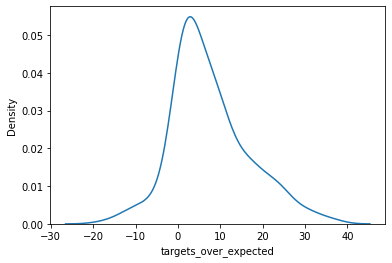

In [ ]:
sns.kdeplot(df_agg['targets_over_expected'])
df_agg['targets_over_expected'].describe()

count    340.000000
mean       0.119789
std        0.033884
min        0.000000
25%        0.102345
50%        0.119830
75%        0.138401
max        0.259375
Name: target_share, dtype: float64

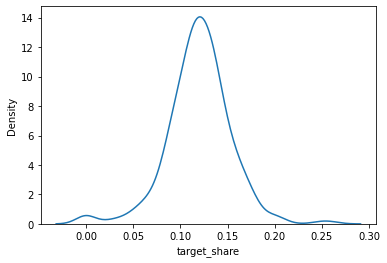

In [ ]:
sns.kdeplot(df_agg['target_share'])
df_agg['target_share'].describe()

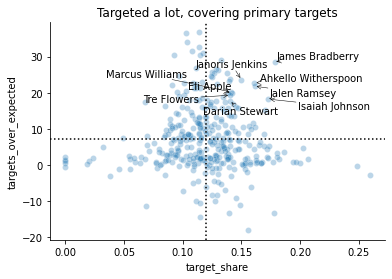

In [ ]:
_df_text = df_agg.loc[(df_agg['target_share']>df_agg['target_share'].mean()) & (df_agg['targets_over_expected']>df_agg['targets_over_expected'].mean())].sort_values('targets_over_expected', ascending=False).head(25)
df_text = df_agg.loc[(df_agg['target_share']>df_agg['target_share'].mean()) & (df_agg['targets_over_expected']>df_agg['targets_over_expected'].mean())].sort_values('target_share', ascending=False).head(25)
df_text = df_text.append(_df_text)
df_text = df_text.loc[df_text.duplicated()]

texts = [plt.text(x['target_share'],x['targets_over_expected'],x['displayName']) for idx,x in df_text.loc[:,['target_share','targets_over_expected','displayName']].iterrows()]
sns.scatterplot(x='target_share',y='targets_over_expected',data=df_agg,alpha=.3)
plt.axvline(df_agg['target_share'].mean(), c='k', ls=':')
plt.axhline(df_agg['targets_over_expected'].mean(), c='k', ls=':')
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='k', lw=0.5))
plt.title('Targeted a lot, covering primary targets')
sns.despine()
plt.show()

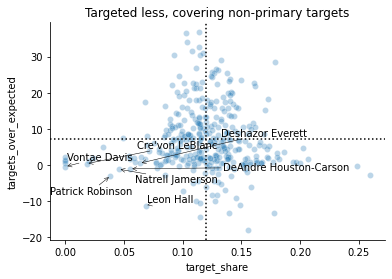

In [ ]:
_df_text = df_agg.loc[(df_agg['target_share']<=df_agg['target_share'].mean()) & (df_agg['targets_over_expected']<=df_agg['targets_over_expected'].mean())].sort_values('targets_over_expected', ascending=True).head(25)
df_text = df_agg.loc[(df_agg['target_share']<=df_agg['target_share'].mean()) & (df_agg['targets_over_expected']<=df_agg['targets_over_expected'].mean())].sort_values('target_share', ascending=True).head(25)
df_text = df_text.append(_df_text)
df_text = df_text.loc[df_text.duplicated()]

texts = [plt.text(x['target_share'],x['targets_over_expected'],x['displayName']) for idx,x in df_text.loc[:,['target_share','targets_over_expected','displayName']].iterrows()]
sns.scatterplot(x='target_share',y='targets_over_expected',data=df_agg,alpha=.3)
plt.axvline(df_agg['target_share'].mean(), c='k', ls=':')
plt.axhline(df_agg['targets_over_expected'].mean(), c='k', ls=':')
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='k', lw=0.5))
plt.title('Targeted less, covering non-primary targets')
sns.despine()
plt.show()

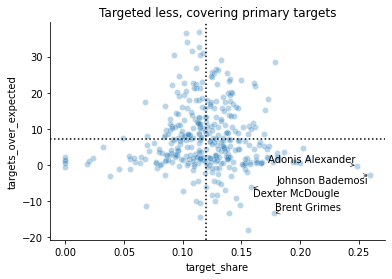

In [ ]:
_df_text = df_agg.loc[(df_agg['target_share']>df_agg['target_share'].mean()) & (df_agg['targets_over_expected']<=df_agg['targets_over_expected'].mean())].sort_values('targets_over_expected', ascending=True).head(30)
df_text = df_agg.loc[(df_agg['target_share']>df_agg['target_share'].mean()) & (df_agg['targets_over_expected']<=df_agg['targets_over_expected'].mean())].sort_values('target_share', ascending=False).head(30)
df_text = df_text.append(_df_text)
df_text = df_text.loc[df_text.duplicated()]

texts = [plt.text(x['target_share'],x['targets_over_expected'],x['displayName']) for idx,x in df_text.loc[:,['target_share','targets_over_expected','displayName']].iterrows()]
sns.scatterplot(x='target_share',y='targets_over_expected',data=df_agg,alpha=.3)
plt.axvline(df_agg['target_share'].mean(), c='k', ls=':')
plt.axhline(df_agg['targets_over_expected'].mean(), c='k', ls=':')
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='k', lw=0.5))
plt.title('Targeted less, covering primary targets')
sns.despine()
plt.show()

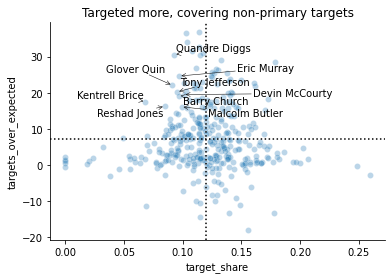

In [ ]:
_df_text = df_agg.loc[(df_agg['target_share']<=df_agg['target_share'].mean()) & (df_agg['targets_over_expected']>df_agg['targets_over_expected'].mean())].sort_values('targets_over_expected', ascending=False).head(30)
df_text = df_agg.loc[(df_agg['target_share']<=df_agg['target_share'].mean()) & (df_agg['targets_over_expected']>df_agg['targets_over_expected'].mean())].sort_values('target_share', ascending=True).head(30)
df_text = df_text.append(_df_text)
df_text = df_text.loc[df_text.duplicated()]

texts = [plt.text(x['target_share'],x['targets_over_expected'],x['displayName']) for idx,x in df_text.loc[:,['target_share','targets_over_expected','displayName']].iterrows()]
sns.scatterplot(x='target_share',y='targets_over_expected',data=df_agg,alpha=.3)
plt.axvline(df_agg['target_share'].mean(), c='k', ls=':')
plt.axhline(df_agg['targets_over_expected'].mean(), c='k', ls=':')
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='k', lw=0.5))
plt.title('Targeted more, covering non-primary targets')
sns.despine()
plt.show()

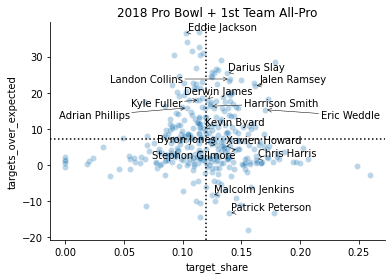

In [ ]:
pb_ap = ['Kevin Byard', 'Eddie Jackson', 'Xavien Howard', 'Harrison Smith', 
         'Kyle Fuller', 'Darius Slay', 'Stephon Gilmore', 'Jalen Ramsey', 
         'Derwin James', 'Byron Jones', 'Chris Harris', 'Patrick Peterson', 
         'Malcolm Jenkins', 'Eric Weddle', 'Adrian Phillips', 'Landon Collins']
df_text = df_agg.loc[(df_agg['displayName'].isin(pb_ap))]
texts = [plt.text(x['target_share'],x['targets_over_expected'],x['displayName']) for idx,x in df_text.loc[:,['target_share','targets_over_expected','displayName']].iterrows()]
sns.scatterplot(x='target_share',y='targets_over_expected',data=df_agg,alpha=.3)
plt.axvline(df_agg['target_share'].mean(), c='k', ls=':')
plt.axhline(df_agg['targets_over_expected'].mean(), c='k', ls=':')
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='k', lw=0.5))
plt.title('2018 Pro Bowl + 1st Team All-Pro')
sns.despine()
plt.show()

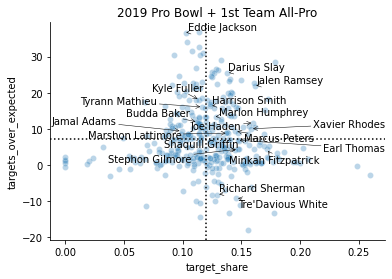

In [ ]:
pb_ap = ['Earl Thomas', 'Harrison Smith', "Tre'Davious White", 'Stephon Gilmore', 
         'Eddie Jackson','Tyrann Mathieu', 'Darius Leonard', 'Richard Sherman', 
         'Joe Haden', 'Marlon Humphrey', 'Marcus Peters', 'Jamal Adams',
         'Marshon Lattimore', 'Darius Slay',  'Jalen Ramsey', 'Minkah Fitzpatrick', 
         'Shaquill Griffin', 'Kyle Fuller', 'Xavier Rhodes', 'Budda Baker']
df_text = df_agg.loc[(df_agg['displayName'].isin(pb_ap))]
texts = [plt.text(x['target_share'],x['targets_over_expected'],x['displayName']) for idx,x in df_text.loc[:,['target_share','targets_over_expected','displayName']].iterrows()]
sns.scatterplot(x='target_share',y='targets_over_expected',data=df_agg,alpha=.3)
plt.axvline(df_agg['target_share'].mean(), c='k', ls=':')
plt.axhline(df_agg['targets_over_expected'].mean(), c='k', ls=':')
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='k', lw=0.5))
plt.title('2019 Pro Bowl + 1st Team All-Pro')
sns.despine()
plt.show()

In [ ]:
df_agg['tier'] = 0
df_agg.loc[(df_agg['target_share']<=df_agg['target_share'].mean()) & (df_agg['targets_over_expected']<=df_agg['targets_over_expected'].mean()), 'tier'] = 4
df_agg.loc[(df_agg['target_share']<=df_agg['target_share'].mean()) & (df_agg['targets_over_expected']>df_agg['targets_over_expected'].mean()), 'tier'] = 3
df_agg.loc[(df_agg['target_share']>df_agg['target_share'].mean()) & (df_agg['targets_over_expected']>df_agg['targets_over_expected'].mean()), 'tier'] = 2
df_agg.loc[(df_agg['target_share']>df_agg['target_share'].mean()) & (df_agg['targets_over_expected']<=df_agg['targets_over_expected'].mean()), 'tier'] = 1

In [ ]:
team_tiers = df_agg.loc[:, ['defTeam', 'targets_over_expected', 'target_share', 'tier']].groupby(['defTeam'], as_index=False).mean()
df_agg['w_tier'] = df_agg['tier'].mul(df_agg['snaps'].mul(-1))
_df_agg = df_agg.loc[:, ['defTeam', 'snaps', 'w_tier']].groupby('defTeam', as_index=False).sum()
_df_agg['w_tier'] = (_df_agg['w_tier'].div(_df_agg['snaps'])).mul(-1)
team_tiers = team_tiers.merge(_df_agg.loc[:, ['defTeam', 'w_tier']])

In [ ]:
team_tiers.sort_values('w_tier')

,defTeam,targets_over_expected,target_share,tier,w_tier
1,ATL,6.200478,0.122153,1.818182,1.564900
2,BAL,6.904175,0.121252,2.000000,1.791896
19,MIN,5.590795,0.139003,1.818182,1.797985
9,DEN,8.346357,0.138733,2.083333,1.842510
29,TB,6.691260,0.142974,1.923077,1.898087
6,CIN,8.096502,0.128231,2.200000,1.919473
27,SEA,9.343004,0.128008,2.222222,1.933425
17,LAC,8.104773,0.118499,2.000000,1.969290
25,PHI,7.538039,0.123091,1.928571,1.983628
28,SF,3.399413,0.140859,2.000000,2.012417


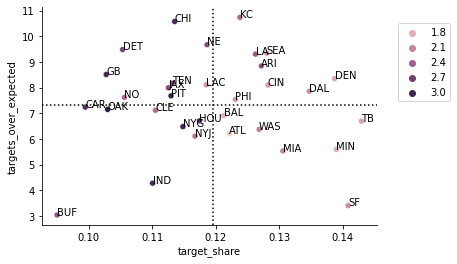

In [ ]:
# df_text = team_tiers.loc[(team_tiers['target_share']>team_tiers['target_share'].mean()) & (team_tiers['targets_over_expected']<=team_tiers['targets_over_expected'].mean())]
df_text = team_tiers
# df_text = df_text.append(_df_text)
# df_text = df_text.loc[df_text.duplicated()]

texts = [plt.text(x['target_share'],x['targets_over_expected'],x['defTeam']) for idx,x in df_text.loc[:,['target_share','targets_over_expected','defTeam']].iterrows()]
sns.scatterplot(x='target_share',y='targets_over_expected',data=team_tiers, hue='w_tier')
plt.axvline(df_agg['target_share'].mean(), c='k', ls=':')
plt.axhline(df_agg['targets_over_expected'].mean(), c='k', ls=':')
# adjust_text(texts, arrowprops=dict(arrowstyle="->", color='k', lw=0.5))
sns.despine()
plt.legend(bbox_to_anchor=(1.05, .95), loc=2)
plt.show()

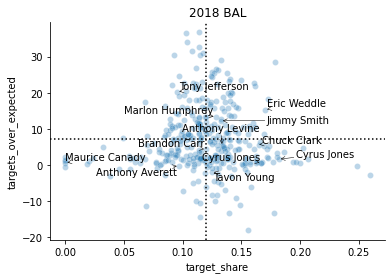

In [ ]:
target_team = 'BAL'
roster = df_agg.loc[df_agg['defTeam']==target_team, 'displayName'].values
df_text = df_agg.loc[(df_agg['displayName'].isin(roster))]
texts = [plt.text(x['target_share'],x['targets_over_expected'],x['displayName']) for idx,x in df_text.loc[:,['target_share','targets_over_expected','displayName']].iterrows()]
sns.scatterplot(x='target_share',y='targets_over_expected',data=df_agg,alpha=.3)
plt.axvline(df_agg['target_share'].mean(), c='k', ls=':')
plt.axhline(df_agg['targets_over_expected'].mean(), c='k', ls=':')
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='k', lw=0.5))
plt.title(f'2018 {target_team}')
sns.despine()
plt.show()

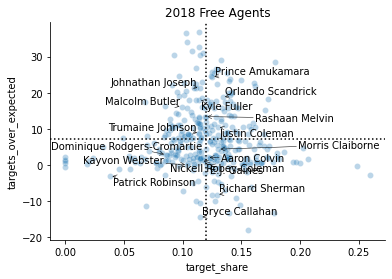

In [ ]:
fas18 = ['Malcolm Butler', 'E.J. Gaines', 'Rashaan Melvin', 'Bryce Callahan', 
       'Trumaine Johnson', 'Patrick Robinson', 'Prince Amukamara', 'Kyle Fuller', 
       'Richard Sherman', 'Johnathan Joseph', 'Morris Claiborne', 'Kayvon Webster', 
       'Ross Cockrell', 'Orlando Scandrick', 'Dominique Rodgers-Cromartie', 
       'Nickell Robey-Coleman', 'Aaron Colvin', 'Delvin Breaux', 'Justin Coleman']

df_text = df_agg.loc[(df_agg['displayName'].isin(fas18))]
texts = [plt.text(x['target_share'],x['targets_over_expected'],x['displayName']) for idx,x in df_text.loc[:,['target_share','targets_over_expected','displayName']].iterrows()]
sns.scatterplot(x='target_share',y='targets_over_expected',data=df_agg,alpha=.3)
plt.axvline(df_agg['target_share'].mean(), c='k', ls=':')
plt.axhline(df_agg['targets_over_expected'].mean(), c='k', ls=':')
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='k', lw=0.5))
plt.title('2018 Free Agents')
sns.despine()
plt.show()

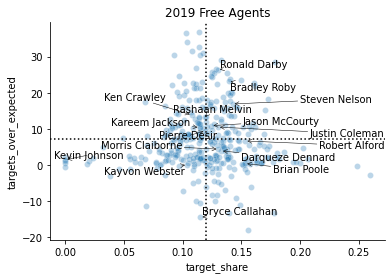

In [ ]:
fas19 = ['Ronald Darby', 'Steven Nelson', 'Bryce Callahan', 'Pierre Desir', 
         'Kareem Jackson', 'Jason McCourty', 'Morris Claiborne', 'Rashaan Melvin', 
         'Darqueze Dennard', 'Justin Coleman', 'Brian Poole', 'Bradley Roby', 
         'Kayvon Webster', 'Robert Alford', 'Ken Crawley', 'Kevin Johnson']

df_text = df_agg.loc[(df_agg['displayName'].isin(fas19))]
texts = [plt.text(x['target_share'],x['targets_over_expected'],x['displayName']) for idx,x in df_text.loc[:,['target_share','targets_over_expected','displayName']].iterrows()]
sns.scatterplot(x='target_share',y='targets_over_expected',data=df_agg,alpha=.3)
plt.axvline(df_agg['target_share'].mean(), c='k', ls=':')
plt.axhline(df_agg['targets_over_expected'].mean(), c='k', ls=':')
adjust_text(texts, arrowprops=dict(arrowstyle="->", color='k', lw=0.5))
plt.title('2019 Free Agents')
sns.despine()
plt.show()